In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, places, viz_tools, visualisations
import xarray as xr
import pandas as pd
import pickle
import os
import bloomdrivers

%matplotlib inline

In [2]:
start=dt.datetime(2015,1,1)
end=dt.datetime(2015,3,31)
year=str(start.year)
modver='201812'

Text(0, 0.5, 'Latitude')

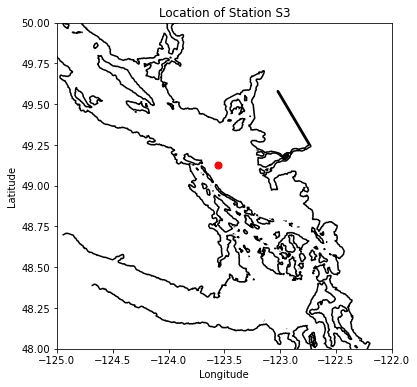

In [3]:
loc='S3'

# lat and lon informatin for place:
lon,lat=places.PLACES['S3']['lon lat']
# get place information on SalishSeaCast grid:
ij,ii=places.PLACES['S3']['NEMO grid ji']
# GEM2.5 grid ji is atm forcing grid for ops files
jw,iw=places.PLACES['S3']['GEM2.5 grid ji']

fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords ='map', isobath=.1)
ax.plot(lon, lat, '.', markersize=14, color='red')
ax.set_ylim(48,50)
ax.set_xlim(-125,-122)
ax.set_title('Location of Station S3')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [4]:
savedir='/ocean/aisabell/MEOPAR/extracted_files'

fname=f'JanToMarch_TimeSeries_{year}_{loc}_{modver}.pkl'
savepath=os.path.join(savedir,fname)
recalc=False

In [5]:
if recalc==True or not os.path.isfile(savepath):
    basedir='/results/SalishSea/nowcast-green.201812/'
    nam_fmt='nowcast'
    flen=1 # files contain 1 day of data each
    ftype= 'ptrc_T' # load bio files
    tres=24 # 1: hourly resolution; 24: daily resolution  
    flist=et.index_model_files(start,end,basedir,nam_fmt,flen,ftype,tres)
    flist3 = et.index_model_files(start,end,basedir,nam_fmt,flen,"grid_T",tres)
    fliste3t = et.index_model_files(start,end,basedir,nam_fmt,flen,"carp_T",tres)

    ik=0
    with xr.open_mfdataset(flist['paths']) as bio:
        bio_time=np.array(bio.time_centered[:])
        sno3=np.array(bio.nitrate.isel(deptht=ik,y=ij,x=ii))
        sdiat=np.array(bio.diatoms.isel(deptht=ik,y=ij,x=ii))
        sflag=np.array(bio.flagellates.isel(deptht=ik,y=ij,x=ii))
        scili=np.array(bio.ciliates.isel(deptht=ik,y=ij,x=ii))
        no3_alld=np.array(bio.nitrate.isel(y=ij,x=ii)) 
        diat_alld=np.array(bio.diatoms.isel(y=ij,x=ii))
        flag_alld=np.array(bio.flagellates.isel(y=ij,x=ii))
        cili_alld=np.array(bio.ciliates.isel(y=ij,x=ii))
        microzoo=np.array(bio.microzooplankton.isel(y=ij,x=ii))
        mesozoo=np.array(bio.mesozooplankton.isel(y=ij,x=ii))
        with xr.open_mfdataset(fliste3t['paths']) as carp:
            intdiat=np.array(np.sum(bio.diatoms.isel(y=ij,x=ii)*carp.e3t.isel(y=ij,x=ii),1)) # depth integrated diatom
            intphyto=np.array(np.sum((bio.diatoms.isel(y=ij,x=ii)+bio.flagellates.isel(y=ij,x=ii)\
                            +bio.ciliates.isel(y=ij,x=ii))*carp.e3t.isel(y=ij,x=ii),1))
            spar=np.array(carp.PAR.isel(deptht=ik,y=ij,x=ii))
    fracdiat=intdiat/intphyto # depth integrated fraction of diatoms

    zoop=microzoo+mesozoo
    sphyto=sdiat+sflag+scili
    phyto_alld=diat_alld+flag_alld+cili_alld
    percdiat=sdiat/sphyto # percent diatoms
    
    with xr.open_mfdataset(flist3['paths']) as grid:
        grid_time=np.array(grid.time_centered[:])
        temp=np.array(grid.votemper.isel(deptht=ik,y=ij,x=ii)) #surface temperature
        salinity=np.array(grid.vosaline.isel(deptht=ik,y=ij,x=ii)) #surface salinity

    opsdir='/results/forcing/atmospheric/GEM2.5/operational'

    flist2=et.index_model_files(start,end,opsdir,nam_fmt='ops',flen=1,ftype='None',tres=24)
    with xr.open_mfdataset(flist2['paths']) as winds:
        u_wind=np.array(winds.u_wind.isel(y=jw,x=iw))
        v_wind=np.array(winds.v_wind.isel(y=jw,x=iw))
        twind=np.array(winds.time_counter)
        solar=np.array(winds.solar.isel(y=jw,x=iw))
    # wind speed:
    wspeed=np.sqrt(u_wind**2 + v_wind**2)
    # wind direction in degrees from east
    d = np.arctan2(v_wind, u_wind)
    winddirec=np.rad2deg(d + (d < 0)*2*np.pi)

    # reading Fraser river flow files
    dfFra=pd.read_csv('/ocean/eolson/MEOPAR/obs/ECRivers/Flow/FraserHopeDaily__Dec-2-2020_10_31_05PM.csv',
                      skiprows=1)
    # the original file contains both flow and water level information in the same field (Value)
    # keep only the flow data, where PARAM=1 (drop PARAM=2 values, water level data)
    # flow units are m3/s
    # DD is YD, year day (ie. 1 is jan 1)
    dfFra.drop(dfFra.loc[dfFra.PARAM==2].index,inplace=True)  

    # rename 'Value' column to 'Flow' now that we have removed all the water level rows
    dfFra.rename(columns={'Value':'Flow'}, inplace=True) 
        # inplace=True does this function on the orginal dataframe

    # no time information so use dt.date
    dfFra['Date']=[dt.date(iyr,1,1)+dt.timedelta(days=idd-1) for iyr, idd in zip(dfFra['YEAR'],dfFra['DD'])]
    # taking the value from the yr column, jan1st date, and making jan1 column to be 1 not 0
    dfFra.head(2)

    # select portion of dataframe in desired date range
    dfFra2=dfFra.loc[(dfFra.Date>=start.date())&(dfFra.Date<=end.date())]
    riv_time=dfFra2['Date'].values
    rivFlow=dfFra2['Flow'].values
    # could also write dfFra['Date'], sometimes this is required
    # newstart is a datetime object, so we convert it to just a date with .date
    pickle.dump((bio_time,sno3,sdiat,sflag,scili,diat_alld,no3_alld,flag_alld,cili_alld,phyto_alld,intdiat,intphyto,zoop,microzoo,mesozoo,spar,fracdiat,sphyto,percdiat,
            grid_time,salinity,temp,u_wind,v_wind,twind,solar,wspeed,winddirec,riv_time,rivFlow),open(savepath,'wb'))
else:
    bio_time,sno3,sdiat,sflag,scili,diat_alld,no3_alld,flag_alld,cili_alld,phyto_alld,intdiat,intphyto,zoop,microzoo,mesozoo,spar,fracdiat,sphyto,percdiat,\
            grid_time,salinity,temp,u_wind,v_wind,twind,solar,wspeed,winddirec,riv_time,rivFlow=pickle.load(open(savepath,'rb'))

### Wind speed cubed (average for each month)

In [6]:
wscubed=bloomdrivers.janfebmar_wspeed3(twind,wspeed)
wscubed

(59.697046212406846, 84.51094917710866, 87.76850855242301)

### surface irradiance and PAR

In [7]:
surface_irradiance=bloomdrivers.janfebmar_irradiance(twind,solar)
print(surface_irradiance)
surface_par=bloomdrivers.janfebmar_spar(bio_time,spar)
print(surface_par)

(43.28905, 76.15834, 121.81198)
(14.1736765, 24.620659, 38.338867)


### surface temperature

In [8]:
surface_temp=bloomdrivers.janfebmar_temp(grid_time,temp)
surface_temp

(7.083027, 8.104258, 8.947551)

### surface salinity

In [9]:
surface_sal=bloomdrivers.janfebmar_temp(grid_time,salinity)
surface_sal

(24.367937, 24.698246, 22.638947)

### fraser river flow

In [32]:
fraserflow=bloomdrivers.janfebmar_fraserflow(riv_time,rivFlow))
fraserflow

(1402.5806451612902, 2062.1428571428573, 2562.9032258064517)


### zooplankton

In [40]:
dzoop=pd.DataFrame(zoop)
szoop=pd.DataFrame(dzoop[[0]])
szoop

,0
0,1.026531
1,1.095775
2,1.131874
3,0.971891
4,0.722009
...,...
85,2.305761
86,2.848837
87,2.517928
88,2.863420


In [33]:

def janfebmar_zooplankton(bio_time,zoop):
    dfzoop=pd.DataFrame({'bio_time':bio_time, 'zoop':zoop})
    monthlyzoop=pd.DataFrame(dfzoop.resample('M', on='bio_time').zoop.mean())
    monthlyzoop.reset_index(inplace=True)
    jan_zoop=monthlyzoop.iloc[0]['zoop']
    feb_zoop=monthlyzoop.iloc[1]['zoop']
    mar_zoop=monthlyzoop.iloc[2]['zoop']
    return jan_zoop, feb_zoop, mar_zoop

print(janfebmar_zooplankton(bio_time,zoop))

Exception: Data must be 1-dimensional

In [10]:
# loop through years

years=list()
windjan=list()
windfeb=list()
windmar=list()
for year in range(2015,2020):
    fname=f'springTimeSeries_{str(year)}_{loc}_{modver}.pkl'
    savepath=os.path.join(saveloc,fname)
    bio_time,sno3,sdiat,sflag,scili,diat_alld,no3_alld,flag_alld,cili_alld,phyto_alld,intdiat,intphyto,spar,fracdiat,sphyto,percdiat,\
            u_wind,v_wind,twind,solar,wspeed,winddirec,riv_time,rivFlow=pickle.load(open(savepath,'rb'))
    # put code that calculates bloom timing here
    wsj=bloomdrivers.metric1_bloomtime(phyto_alld,no3_alld,bio_time)
    wsf=bloomdrivers.metric2_bloomtime(sphyto,sno3,bio_time)
    wsm=bloomdrivers.metric3_bloomtime(sphyto,sno3,bio_time)
    years.append(year)
    windjan.append(wsj)
    windfeb.append(wsf)
    windmar.append(wsm)   
years=np.array(years)
bloomtime1=np.array(bloomtime1)
bloomtime2=np.array(bloomtime2)
bloomtime3=np.array(bloomtime3)

NameError: name 'saveloc' is not defined